# Entrenando un modelo de IA usando datos EMG

In [2]:
# Importar las librerias necesaria
import pandas as pd
import numpy as np
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Dropout
import sklearn
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

In [5]:
# Nombre de los sensores empleados.
emg_columns = ["EMG1", "EMG2", "EMG3", "EMG4", "EMG5", "EMG6"]

# Asignar a cada carpeta un identificador correspondiente a una tarea motora.
FOLDER_2_LABEL = {"task1": 0, "task2": 1, "task3": 2, "task4": 3}

# Frecuencia de Muestreo de la señal.
ORIGINAL_FREC = 100 # Hz
# Tiempo de muestreo de un sample.
SAMPLE_TIME = 2.5
TOTAL_DATA = int(SAMPLE_TIME*ORIGINAL_FREC)

# Path donde se almacenan los datos.
MAIN_PATH = "data"

# Path para guardar las características calculadas.
FEATURES_PATH = "Features.csv"

In [3]:
def filter_signal(df: pd.DataFrame, window_size: int):
    """
    Filtrar la señal usando el método de la media móvil.
    Params:
        df: contiene los datos emg, siendo
            cada columna el registro de un
            sensor. 
        window_size: tamano de la ventana móvil.
    Return:
        df_filtered (Dataframe): contiene los datos EMG 
                                 filtrados por columna.
    """
    df_filtered = df.rolling(window_size).mean()
    df_filtered.dropna(inplace=True)
    return df_filtered

def normalize_columns(df: pd.DataFrame):
    """
    Normalizar las columnas aplicando el 
    método de normalización min-max.
    """
    df_normalized = (df-df.min())/(df.max()-df.min())
    return df_normalized

def calculate_features(df: pd.DataFrame, label: int):
    """
    Calcula las características de la señal por sensor,
    usando el método del valor RMS.
    Params:
        df: contiene los datos emg, siendo
            cada columna el registro de un
            sensor.
        label: el identificador de la tarea motora a
               la que corresponde esa señal.
    Return:
        features_list (list): contiene el label de la
                              señal y las características. 
    """
    features_list = []
    for sensor in emg_columns:
        for i in range(0, 250, 50):
            features_list.append(np.sqrt(np.mean(df.iloc[i:i+50][sensor]**2)))
    features_list.insert(0, label)
    return features_list

## Filtrado - Normalización - Extracción de características

Nota: Para calcular y usar el valor RMS de una senal como entrada de un modelo, se debe procurar escoger una ventana no tan grande, ya que la senal podría dejar de ser representativa.

In [4]:
# El tamano de la ventana para calcular las características.
WINDOW_RMS = 50

# El tamano de la ventana inicial debe ser divisible para el tamano de la ventana RMS.
assert(TOTAL_DATA % WINDOW_RMS == 0)

# Generar una lista que contenga los nombres de las características a calcular.
features_column = ['RMS' + str(x) + '_' + sensor for sensor in emg_columns for x in range(WINDOW_RMS,TOTAL_DATA+WINDOW_RMS, WINDOW_RMS)]
features_column.insert(0,"Label")

# Inicializar el Dataframe que contendrá las características calculadas más adelante.
df_features = pd.DataFrame(columns=features_column)

# Recorrer cada carpeta.
for folder in os.listdir(MAIN_PATH):
    folder_path = os.path.join(MAIN_PATH, folder)
    # Recorrer cada archivo de la carpeta.
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        # Leer las senales EMG.
        df = pd.read_csv(file_path, names=emg_columns, index_col=False)
        # Filtrar las senales EMG.
        df_filtered = filter_signal(df, 2)
        # Normalizar las senales EMG.
        df_norm = normalize_columns(df_filtered)
        # Calcular las características del respectivo archivo.
        features = calculate_features(df_norm, FOLDER_2_LABEL[folder])
        # Agregar las características calculadas al Dataframe df_features.
        df_features.loc[len(df_features)] = features

In [5]:
# Escribir el Dataframe con las características.
df_features.to_csv(FEATURES_PATH, index=False)

## Entrenamiento del modelo

In [6]:
# Definir una semilla.
RANDOM_STATE = 42

# Establecer el porcentaje para dividir la data.
TRAIN_SPLIT = 0.6
VALID_TEST_SPLIT = 0.2
assert(TRAIN_SPLIT + (2*VALID_TEST_SPLIT) == 1)

# Definir la taza de aprendizaje.
LEARNING_RATE = 0.001

# Definir el número de épocas.
EPOCHS = 200

# Definir el tamaño del batch.
BATCH_SIZE = 64

In [7]:
# Leer archivo con características de las señales EMG.
features_df = pd.read_csv(FEATURES_PATH)

In [10]:
# Convertir la columna a tipo int.
features_df["Label"] = features_df["Label"].astype(int)
# Asegurarnos de no introducir datos vacíos.
features_df.dropna(inplace=True)
# Hacer un shuffle a los datos.
features = features_df.sample(frac=1, random_state=RANDOM_STATE)
# Convertir a un arreglo de numpy (ya que el modelo trabaja con este tipo de datos).
features = features.to_numpy()

# Separar los datos entre el target (el id de la tarea motora) y las características.
# Nota: En este caso en específico se usa la función to_categorical, ya que 
# la función de pérdida que se usó en el modelo requiere de variables categóricas.
y_values = keras.utils.to_categorical(features[:,0], num_classes=4)
x_values = features[:,1:].astype('float32')

# Separar los datos en TRAINING, TESTING Y VALIDATION.
TRAIN_SPLIT =  int(TRAIN_SPLIT * features.shape[0])
TEST_SPLIT = int(VALID_TEST_SPLIT * features.shape[0] + TRAIN_SPLIT)
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Asegurar que la división de los datos fue exitosa.
assert(x_train.shape[0] + x_test.shape[0] + x_validate.shape[0] == features.shape[0])

In [16]:
# Definir la arquitectura del modelo
model = Sequential()
model.add(Dense(60, input_shape = (x_train.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30, input_shape = (x_train.shape[1],),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

In [17]:
# Definir la función de optimización y sus hiperparámetros.
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# Definir la función de pérdida y compilar el modelo.
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Entrenar el modelo
start = time.time()
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                            validation_data=(x_validate, y_validate))
stop = time.time()
print(f"Total training time: {stop - start}s")
test_results = model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
4/4 [==============================] - 1s 137ms/step - loss: 1.4430 - accuracy: 0.1417 - recall_2: 0.0042 - precision_2: 0.1667 - val_loss: 1.3850 - val_accuracy: 0.3000 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 2/200
4/4 [==============================] - 0s 12ms/step - loss: 1.3947 - accuracy: 0.2917 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - val_loss: 1.3767 - val_accuracy: 0.2875 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 3/200
4/4 [==============================] - 0s 14ms/step - loss: 1.3797 - accuracy: 0.2667 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - val_loss: 1.3732 - val_accuracy: 0.3125 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 4/200
4/4 [==============================] - 0s 14ms/step - loss: 1.3770 - accuracy: 0.2667 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - val_loss: 1.3685 - val_accuracy: 0.3250 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 5/200
4/4 [======

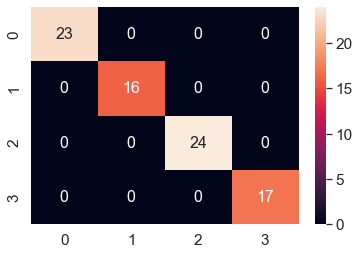

In [11]:
# Testear el modelo
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Definir la matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()